# Imports

In [1]:
import numpy as np #No using automatic differentiation allowed from here!
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import sklearn.metrics as metrics

## Class template

In [2]:
def sigmoid(z):
    return 1/ (1 + np.exp(-z))

def sigmoidGradient(z):
    sig = sigmoid(z)
    return sig *(1-sig) 

def randInitializeWeights(L_in, L_out):
    epi = (6**1/2) / (L_in + L_out)**1/2
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    return W

In [3]:
class NeuralNetworkClassifier: 
    def __init__(self, layers): 
        self.input_layer_size  = layers[0][0]
        self.hidden_layer_size = layers[1][0]
        self.num_labels = layers[2][0]
        initial_Theta1 = randInitializeWeights(self.input_layer_size, self.hidden_layer_size)
        initial_Theta2 = randInitializeWeights(self.hidden_layer_size, self.num_labels)
        self.nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())
        self.Lambda = 0
        
    def predict(self, X): 
        Theta1 = self.nn_params[:((self.input_layer_size+1) * self.hidden_layer_size)].reshape(self.hidden_layer_size,self.input_layer_size+1)
        Theta2 = self.nn_params[((self.input_layer_size +1)* self.hidden_layer_size ):].reshape(self.num_labels,self.hidden_layer_size+1)
        m= X.shape[0]
        X = np.hstack((np.ones((m,1)),X))
        a1 = sigmoid(X @ Theta1.T)
        a1 = np.hstack((np.ones((m,1)), a1))
        a2 = sigmoid(a1 @ Theta2.T)
        return np.argmax(a2,axis=1)+1
       
    def fit_once(self, X, y,alpha =1.0): 
        Theta1 = self.nn_params[:((self.input_layer_size+1) * self.hidden_layer_size)].reshape(self.hidden_layer_size,self.input_layer_size+1)
        Theta2 = self.nn_params[((self.input_layer_size +1)* self.hidden_layer_size ):].reshape(self.num_labels,self.hidden_layer_size+1)
        cost, grad1, grad2 = self.categorical_cross_entropy_loss(X,y)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        self.nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        return cost
    
    def categorical_cross_entropy_loss(self,X, y):
        Lambda = self.Lambda
        Theta1 = self.nn_params[:((self.input_layer_size+1) * self.hidden_layer_size)].reshape(self.hidden_layer_size,self.input_layer_size+1)
        Theta2 = self.nn_params[((self.input_layer_size +1)* self.hidden_layer_size ):].reshape(self.num_labels,self.hidden_layer_size+1)
        m = X.shape[0]
        J=0
        X = np.hstack((np.ones((m,1)),X))
        y10 = np.zeros((m,self.num_labels))
        a1 = sigmoid(X @ Theta1.T)
        a1 = np.hstack((np.ones((m,1)), a1))
        a2 = sigmoid(a1 @ Theta2.T)
        for i in range(1,self.num_labels+1):
            y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        for j in range(self.num_labels):
            J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
        cost = 1/m* J
        reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
        grad1 = np.zeros((Theta1.shape))
        grad2 = np.zeros((Theta2.shape))
        for i in range(m):
            xi= X[i,:] 
            a1i = a1[i,:]
            a2i =a2[i,:]
            d2 = a2i - y10[i,:]
            d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
            grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
            grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        grad1 = 1/m * grad1
        grad2 = 1/m*grad2
        grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
        grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
        return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

# Train on Mnist

In [4]:
from scipy.io import loadmat
mat=loadmat("train_data.mat")
X=mat["X"]
y=mat["y"]

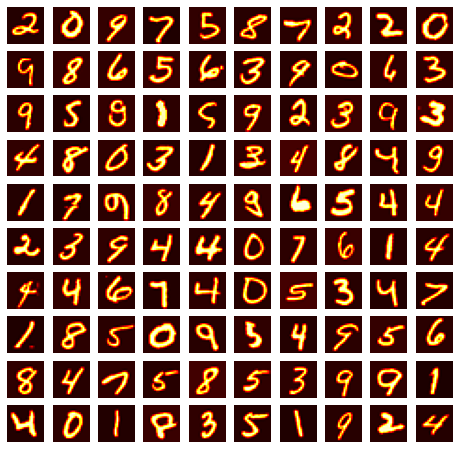

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")

In [6]:
model = NeuralNetworkClassifier([(X.shape[1], "relu"), (50, "relu"), (10, "softmax")])

In [7]:
losses = [] 
NUM_ITERS = 2000
for i in range(NUM_ITERS):
    cost = model.fit_once(X, y)
    if i % 1000 == 0:
        print(cost)
    losses.append(cost)

6.917758866479338
0.3160095703037198


In [8]:
predictions = model.predict(X)

In [9]:
predictions[:10]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [10]:
(np.sum((np.reshape(y,(-1,)) == np.reshape(predictions,(-1,))).astype(int)) / X.shape[0]) * 100

98.18